<a href="https://colab.research.google.com/github/ChrisKantor/CAP-6415-Computer-Vision/blob/main/CV_Module_5_3__Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code: LeNet

##Code (support): `Animator` class

In [1]:
from IPython import display
!pip install d2l==0.16.2
from d2l import torch as d2l

class Animator:
    """For plotting data in animation."""
    def __init__(self, title=None, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 10)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []

        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)

        #adding a title to the figure
        if title != None:
          self.axes.title.set_text(title)


        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y, title):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n  #repeat x axis values n times, one for each plot
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()

        self.axes[0].set_title(title)   #adding title to subplot

        display.display(self.fig)
        display.clear_output(wait=True)

    def saveImage(self, image_title):
        self.fig.savefig(image_title + '.png')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 738.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00


## Code (support): `Accumulator`



In [2]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # creates [0.0, 0.0, ....n-times]

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # Example: let self.data = [10, 15] and args be [3, 4]
        # zip(self.data, args) will produce the paired iterable [(10, 3), (15, 4)]
        # the for loop with go over these paired entries adding them up to result in [13, 19]

    def reset(self):
        self.data = [0.0] * len(self.data) # creates [0.0, 0.0, ....n-times]

    def __getitem__(self, idx):
        return self.data[idx]

## Code (support): `evaluate_accuracy`

In [3]:
def accuracy (y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #The output is a vector -- not just a scalar
        y_hat = y_hat.argmax(axis=1)
    cmp = (y_hat.type(y.dtype) == y)
    return float(cmp.type(y.dtype).sum())

In [4]:
def evaluate_accuracy (net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter: # iterate over the minibatches
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## Code: `train_full`

In [5]:
#-------------------------------------------------------------------------------
import time
def train_one_epoch (net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
            X, y = X.to(device), y.to(device) # Move data to device - GPU or CPU as set
            # Compute gradients and update parameters
            y_hat = net(X)
            l = loss(y_hat, y)

            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]



#-------------------------------------------------------------------------------
#changing train_full to take a title, optimizer, and initializer
def train_full (net, train_iter, test_iter, num_epochs, lr, title):

    animator = Animator(title=title, xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
                       legend=['train loss', 'train acc', 'test acc'])


    #----------------------Initialize-----------------------------------------
    # There is a default initialization in pytorch uses a uniform distribution bounded by 1/sqrt(in_features),
    # However, this might not be the best one to use. Weight initialization has a great impact on the
    # quality of the final network weights.
    # Good discussions on initialization can be found at
    # https://towardsdatascience.com/how-to-initialize-a-neural-network-27564cfb5ffc
    # https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html
    # Below code allows you to use other well known initialization strategies.
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
          nn.init.xavier_normal_(m.weight)

    # Uncomment the below if you want to do other types of initializations
    net.apply(init_weights)


    #-----------------------Loss Function--------------------------------------
    loss = nn.CrossEntropyLoss()


    #-----------------------Optimizer--------------------------------------
    # There are different kind of optimizers. The one we studied earlier, stochastic gradient descent (SGD)
    # is but only one type. There are more. See https://pytorch.org/docs/stable/optim.html
    optimizer = torch.optim.Adam (net.parameters(), lr=lr)
    #----------------------------------------------------------------------

    #-----------------------Iterate over epochs--------------------------------------
    history = [[], [], []]    #store train loss, train acc, test acc in an array of arrays to return later

    for epoch in range(num_epochs):
        start_time = time.time()
        #with torch.cuda.device(0):
        train_metrics = train_one_epoch (net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        end_time = time.time() - start_time
        #print ('Epoch:', epoch + 1, 'time: %4.3f'%(end_time), '(loss: %4.3f, train acc: %4.3f, test acc: %4.3f)'%(train_metrics[0],  train_metrics[1], test_acc))

        #################################################################################################
        #train loss = train_metrics[0], train acc = train_metrics[1], test acc = test_acc
        #append these results to history
        history[0].append(train_metrics[0])
        history[1].append(train_metrics[1])
        history[2].append(test_acc)

        animator.add(epoch + 1, train_metrics + (test_acc,), title)

    train_loss, train_acc = train_metrics
    animator.saveImage(title)
    return (train_loss, train_acc, test_acc), history

# Assignment - Hyperparameter optimization

Starting from the LeNet5 as defined above in this notebook, try three of the following variations.

For each variation, start from the choices used in the code above and find the best option. Decide on the best choice as per test accuracy. Report the performances in one aggregated table.


* Hyperparameters to vary (Choose any three):
    1. Different optimization functions - https://pytorch.org/docs/stable/optim.html: SGD, Adam, RMSProp
    1. Batch_size = 32, 64, 128
    1. Convolution kernel sizes: 3, 5
    1. Number of output channels: (4, 12), (6, 16)
    1. Pooling: average pooling, maximum pooling.
    1. Activation function: softmax, ReLU, LeakyReLU
    1. Number of convolution layer: 1, 2, 3
    1. Number of fully connected layers: 1, 2
    1. (Learning rate, #epochs):  (0.0001, 100), (0.001, 50),  (0.01, 25),
    1. Initializations: (i) default, (ii) xavier_normal_, and (iii) kaiming_normal_


* In your report,

    1. Show the learning process by plotting the train and test accuracy using three figures. Create one figure for each of the choosen three variations. In the 11-th figure, plot the best case for each of the nine cases above. Give some thought on how to plot the curves so that they are distinguishable. Label the axes and use legends.

    2. Report the hyperparameter that results in the best test performance.

    3. Include one learning plot example of overfitting.

    4. Display the activations (outputs) of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).


In [6]:
#assignment code
#Choosing batch size, optimization functions, and initializers
#creating dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as transforms

FashionMNIST_classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                        'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
transform_FashionMNIST = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform_FashionMNIST)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_FashionMNIST)

100%|██████████| 26421880/26421880 [00:02<00:00, 9556400.20it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 161025.41it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3124609.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17287651.71it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



(0.2761331726690133, 0.89625, 0.8882)
(32, 'max', 0.001, 10)
0.8882
['Pooling Type: avg', (0.32725114524364474, 0.8781, 0.8621)]
['Pooling Type: max', (0.2761331726690133, 0.89625, 0.8882)]
[[0.8850939110040664, 0.5475905318101247, 0.47663233043352765, 0.43683643863201144, 0.40732531894842783, 0.38618523938258487, 0.3668930545369784, 0.3516788496911526, 0.33814758605162304, 0.32725114524364474], [0.6758166666666666, 0.7922666666666667, 0.8231333333333334, 0.83835, 0.8491, 0.8559833333333333, 0.8651666666666666, 0.8695166666666667, 0.8745, 0.8781], [0.7644, 0.8062, 0.8251, 0.8405, 0.8389, 0.8551, 0.8583, 0.8596, 0.8534, 0.8621]]
[[0.8777611578702926, 0.49209690674146017, 0.4207271819591522, 0.37881871899962427, 0.3509498582402865, 0.32950212322672207, 0.31303317316969237, 0.2999146346062422, 0.286678800012668, 0.2761331726690133], [0.6764666666666667, 0.81415, 0.8453, 0.8615333333333334, 0.87015, 0.8787166666666667, 0.8849833333333333, 0.8879333333333334, 0.8932833333333333, 0.89625], [

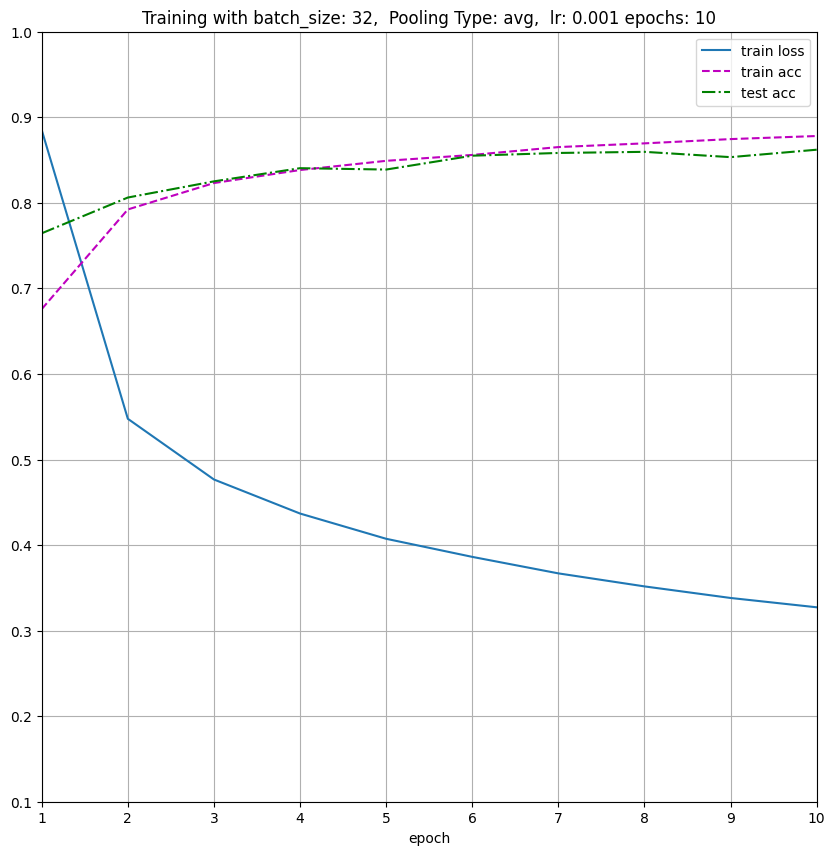

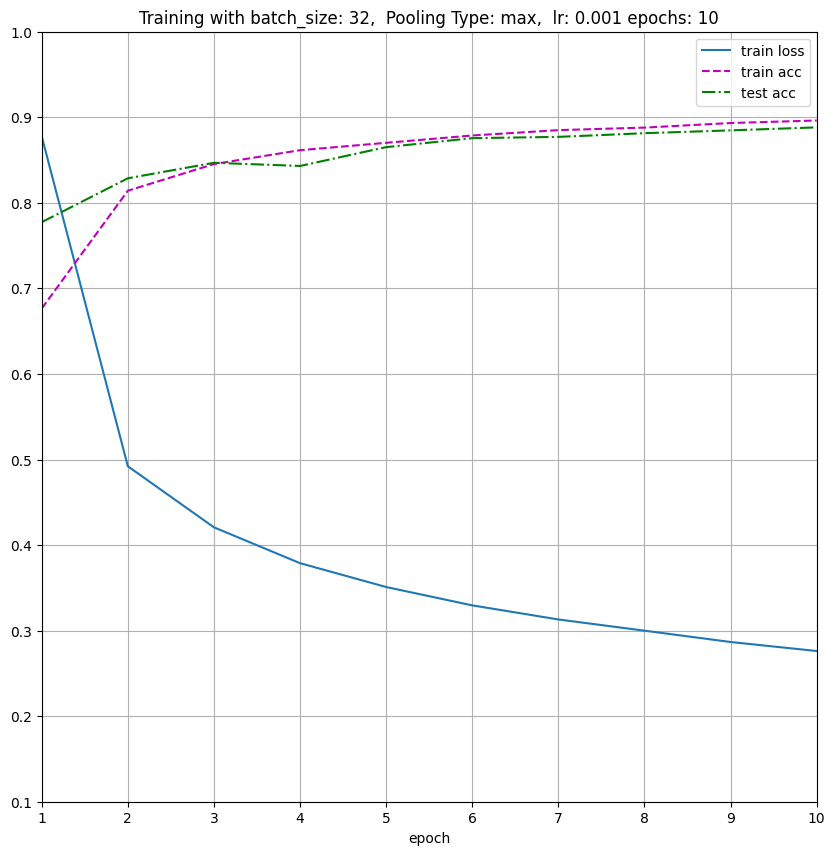

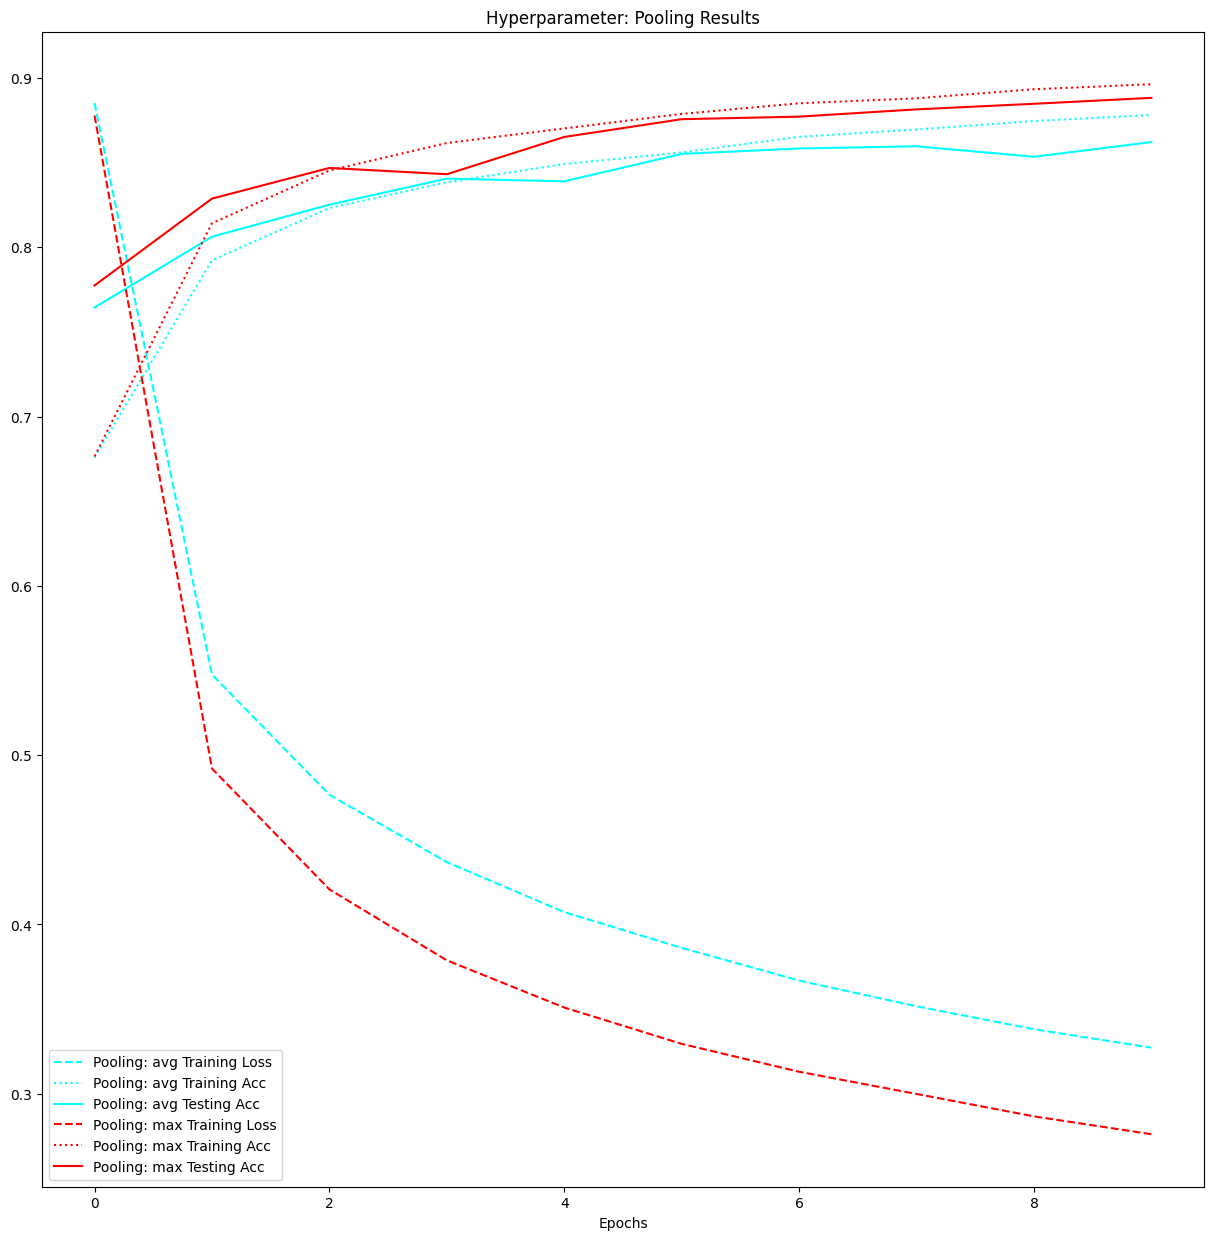

In [7]:
batch_sizes = [32]                      #default = [32]             #[32, 64, 128]
pooling_types = ['avg', 'max']       #default = ['avg']          #['avg', 'max']
lr_epochs = [(0.001, 10)]           #Default =[(0.001, 10)]     #[(0.0001, 100), (0.001, 50), (0.01, 25)]

best_test_acc = 0.0
best_test = None
best_model = None
results = []

#store the history of ALL hyperparam tests
histories = []

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


for batch_size in batch_sizes:
    train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

    for pool in pooling_types:
        if pool == 'avg':
            poolingLayer = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            poolingLayer = nn.MaxPool2d(kernel_size=2, stride=2)


        for lr, num_epochs in lr_epochs:
            net = nn.Sequential(# First convolution layer
                        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                        nn.Sigmoid(), #activation layer
                        poolingLayer,

                        # Second convolution layer
                        nn.Conv2d(6, 16, kernel_size=5),
                        nn.Sigmoid(), #activation layer
                        poolingLayer,

                        # Third fully connected (FC) layer
                        nn.Flatten(),
                        nn.Linear(16 * 5 * 5, 120),
                        nn.Sigmoid(),

                        # Fourth fully connected (FC) layer
                        nn.Linear(120, 84),
                        nn.Sigmoid(),

                        # Fifth fully connected (FC) layer
                        nn.Linear(84, 10))
            net.to(device)

            #set optimizer and initializer in train_full
            title = f'Training with batch_size: {batch_size},  Pooling Type: {pool},  lr: {lr} epochs: {num_epochs}'
            res, history = train_full (net, train_iter, test_iter, num_epochs, lr, title);    #returns res=(train_loss, train_acc, test_acc), history=[[train loss hist], [train acc hist], [test acc hist]]
            print(res)
            results.append([f'Pooling Type: {pool}', res])
            if res[2] > best_test_acc:
                best_test_acc = res[2]
                best_test = (batch_size, pool, lr, num_epochs)
                best_model = net
            histories.append(history)


print(best_test)
print(best_test_acc)
for result in results:
    print(result)


colors = ['cyan', 'red', 'blue']
hyperParam = 'Pooling'
hyperParamChoices = ['avg', 'max']
fig, axes = plt.subplots(figsize=(15, 15))
axes.title.set_text(f'Hyperparameter: {hyperParam} Results')
axes.set_xlabel('Epochs')

#for each hyperparam choice's history
#first choice is cyan
#second choice is red
#third choice (if any) is blue
for i in range(len(histories)):
    hist = histories[i]
    print(hist)
    curColor = colors[i]

    #training loss is dashed, training acc is dotted, and testing acc is solid
    plt.plot(hist[0], label=f'{hyperParam}: {hyperParamChoices[i]} Training Loss', color=curColor, linestyle='dashed') # plotting by columns
    plt.plot(hist[1], label=f'{hyperParam}: {hyperParamChoices[i]} Training Acc', color=curColor, linestyle='dotted') # plotting by columns
    plt.plot(hist[2], label=f'{hyperParam}: {hyperParamChoices[i]} Testing Acc', color=curColor) # plotting by columns

axes.legend()
fig.savefig(f'{hyperParam}_Aggregate_Figure' + '.png')
plt.show()

f = open(f"results_{hyperParam}.txt", "w")
for res in results:
    f.write(str(res) + '\n')
f.close()

torch.save(best_model.state_dict(), f'bestModel_{hyperParam}.pt')

Total parameters: 61706
Conv2d output shape:	 Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Sigmoid output shape:	 Sigmoid()
MaxPool2d output shape:	 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d output shape:	 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Sigmoid output shape:	 Sigmoid()
MaxPool2d output shape:	 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Flatten output shape:	 Flatten(start_dim=1, end_dim=-1)
Linear output shape:	 Linear(in_features=400, out_features=120, bias=True)
Sigmoid output shape:	 Sigmoid()
Linear output shape:	 Linear(in_features=120, out_features=84, bias=True)
Sigmoid output shape:	 Sigmoid()
Linear output shape:	 Linear(in_features=84, out_features=10, bias=True)






Input Image: Ankle boot


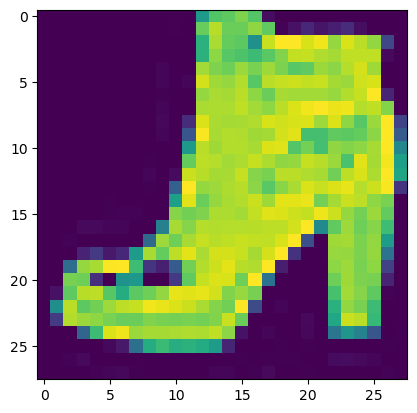

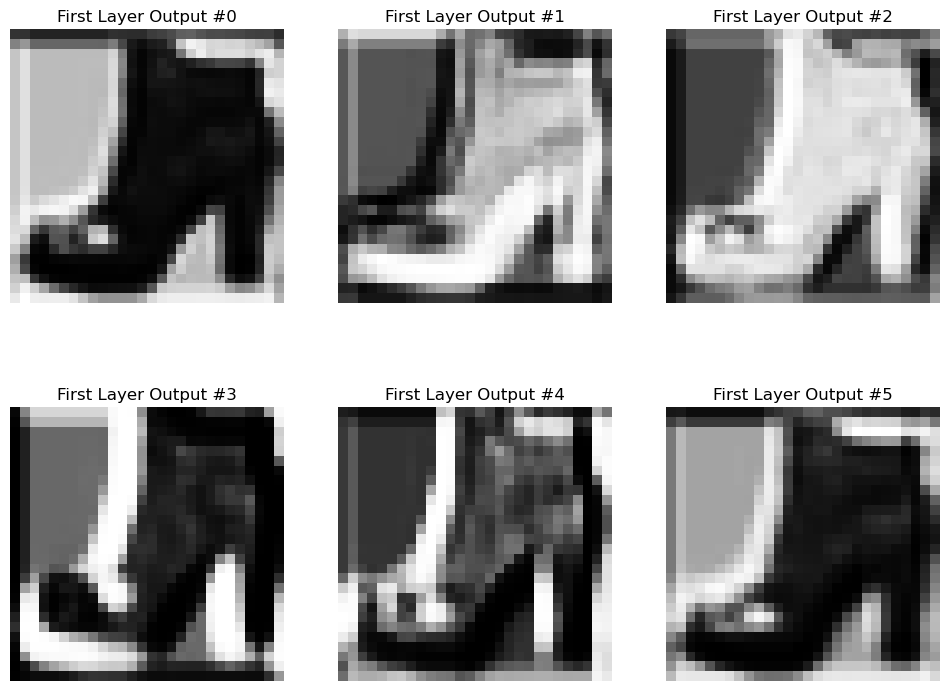

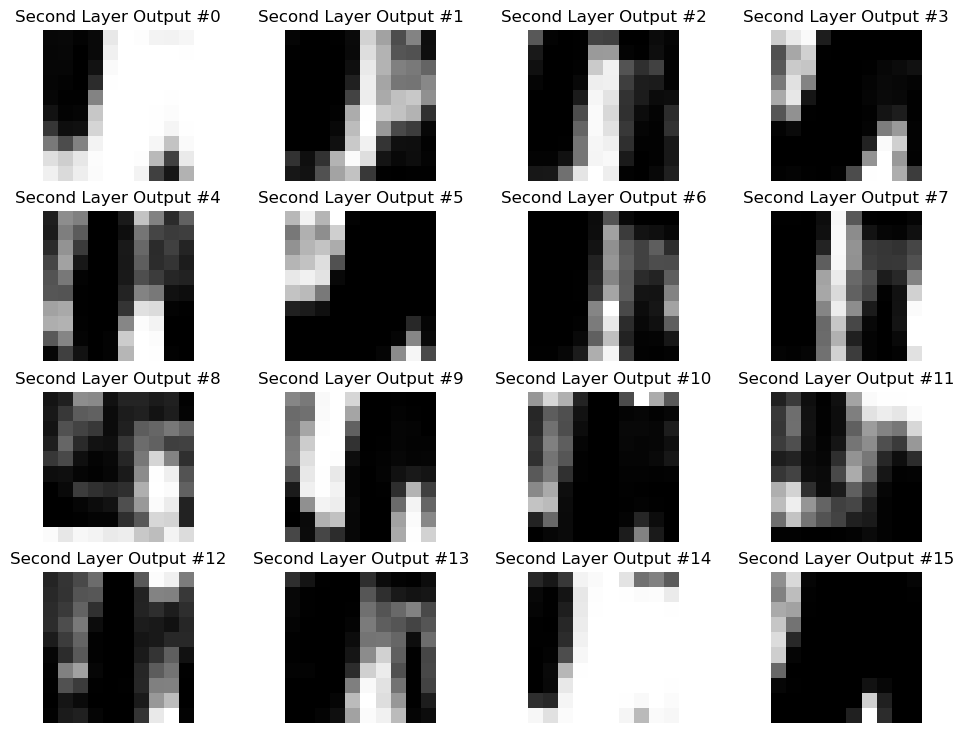




Input Image: Sneaker


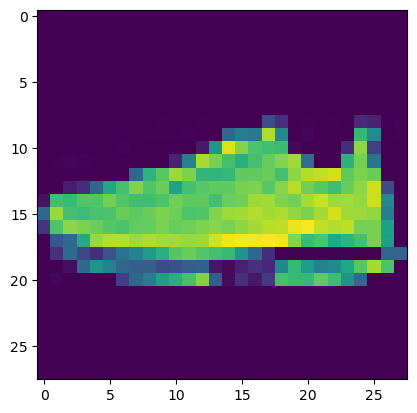

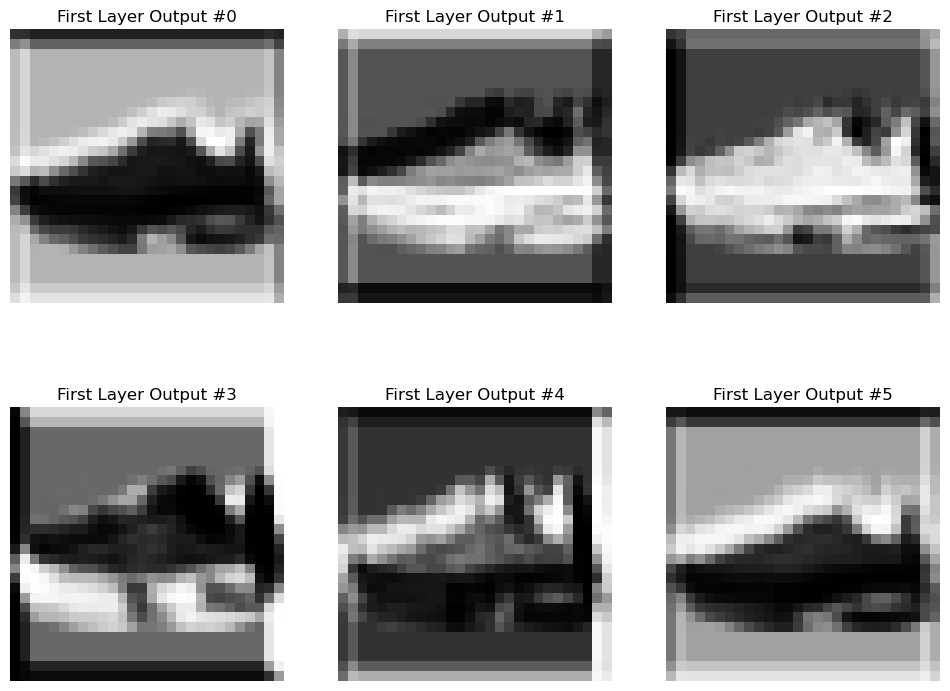

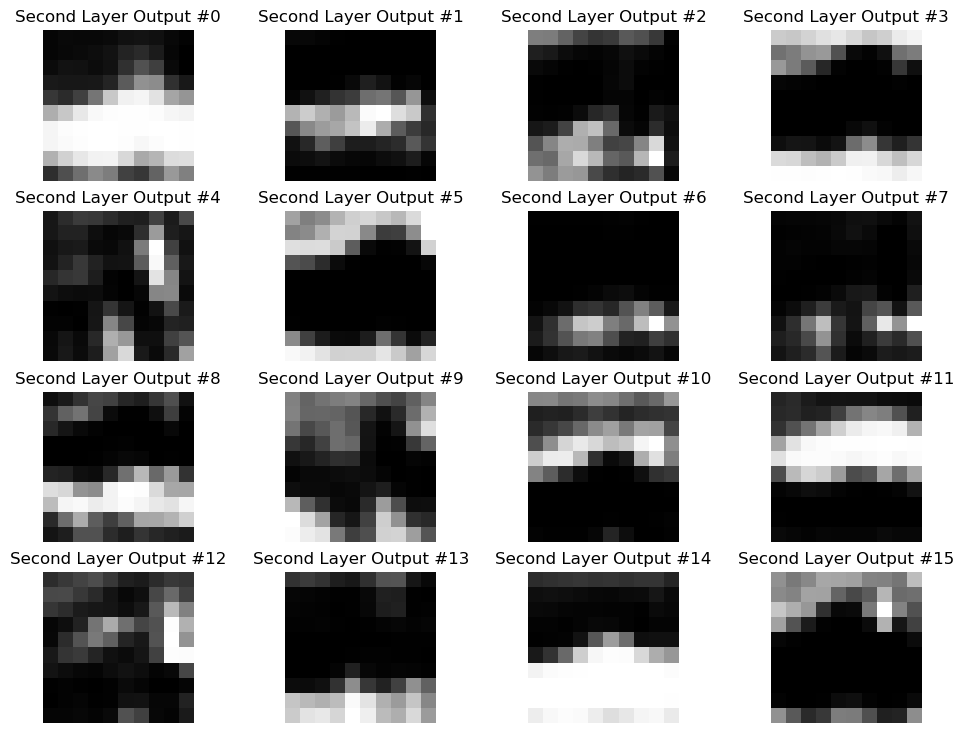




Input Image: T-shirt


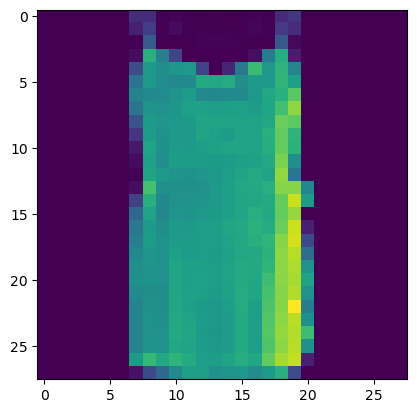

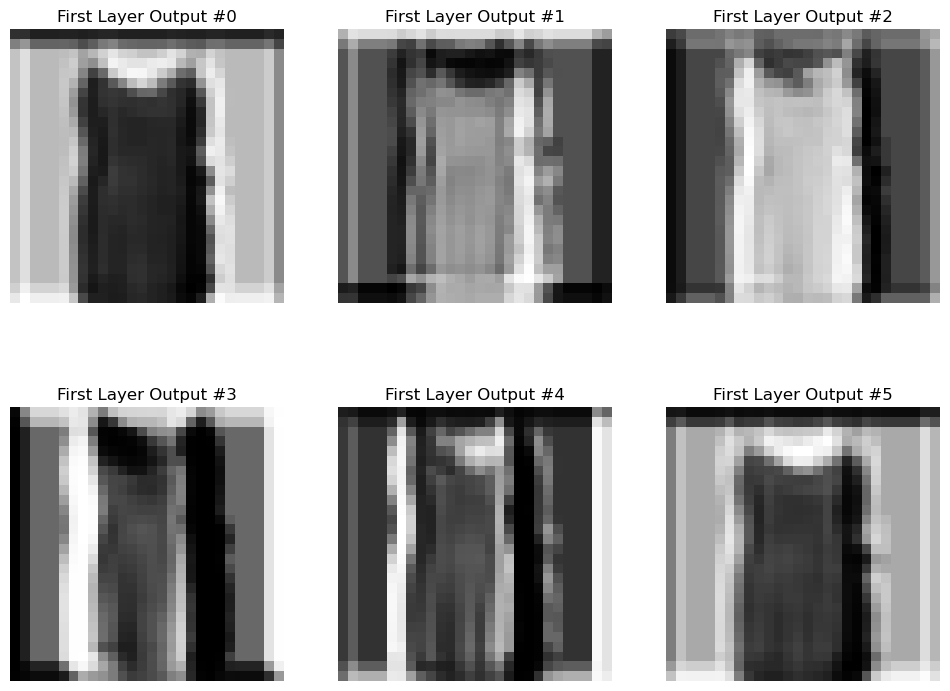

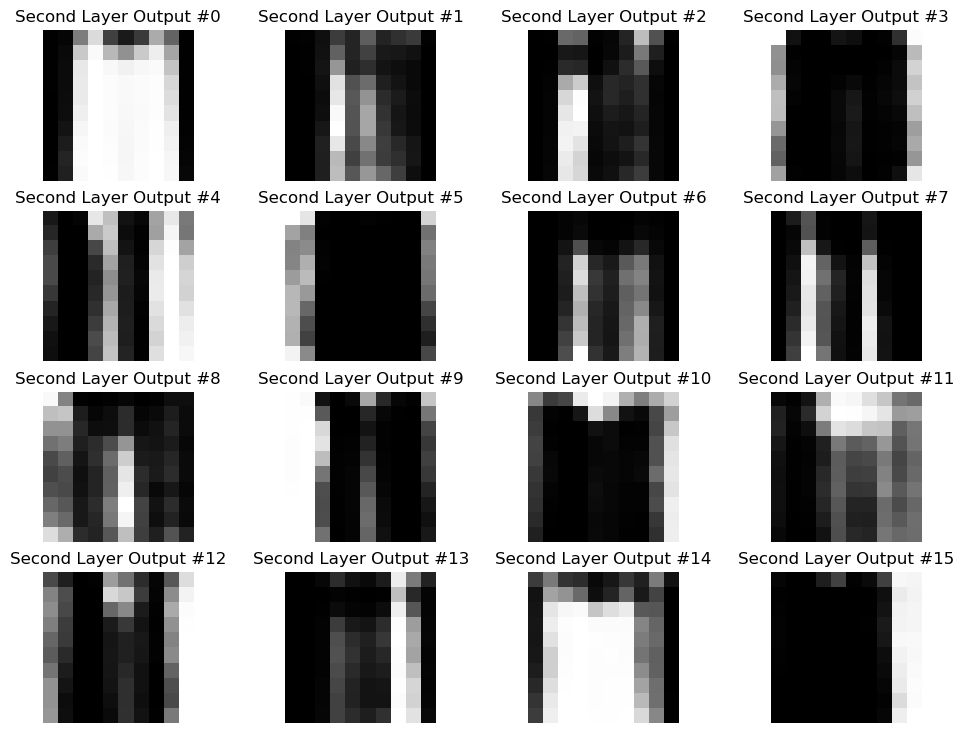

In [ ]:
#assignment pt 4 - displaying layer outputs
#creating model
best_model = nn.Sequential(# First convolution layer
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                nn.Sigmoid(), #activation layer
                nn.MaxPool2d(kernel_size=2, stride=2),


                # Second convolution layer
                nn.Conv2d(6, 16, kernel_size=5),
                nn.Sigmoid(), #activation layer
                nn.MaxPool2d(kernel_size=2, stride=2),

                # Third fully connected (FC) layer
                nn.Flatten(),
                nn.Linear(16 * 5 * 5, 120),
                nn.Sigmoid(),

                # Fourth fully connected (FC) layer
                nn.Linear(120, 84),
                nn.Sigmoid(),

                # Fifth fully connected (FC) layer
                nn.Linear(84, 10))
best_model.load_state_dict(torch.load('bestModel_Pooling.pt'))
best_model.eval()

train_iter = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=True, num_workers=2)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    npimg = img.to("cpu")
    npimg = npimg.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #reorder into (row, col, color)
    plt.show()
    plt.close()


total_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
print('Total parameters:', total_params)

for layer in best_model :
    print(layer.__class__.__name__, 'output shape:\t', layer)

print('\n\n')

# get 3 random training images
images, labels = next(iter(train_iter))

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

#move model and images to the device
best_model.to(device)
images, labels = images.to(device), labels.to(device)

#for each of these training images:
for i in range(3):

    #display them and the label
    print('\n\n\nInput Image: ' + FashionMNIST_classes[labels[i]])
    imshow(images[i])

    inputBatch = images[i].unsqueeze(0)
    X = inputBatch
    first = True
    second = True

    for layer in best_model:
        X = layer(X) # The output of a layer is the input to the next layer in the following iteration.

        #if this is an activation layer (sigmoid)
        if (layer.__class__.__name__ == 'Sigmoid'):

            #if this is the first activation layer
            if first:
                fig, ax = plt.subplots(nrows=2, ncols=3)  #first convolution layer has 6 outputs
                fig.set_size_inches (12, 9)
                for j in range(6):
                    temp = X[0, j, :].to("cpu")
                    ax[np.unravel_index(j, (2, 3))].imshow(temp.detach().numpy(), 'gray')
                    ax[np.unravel_index(j, (2, 3))].set_title('First Layer Output #%d'%(j))
                    ax[np.unravel_index(j, (2, 3))].axis('off')

                first = False

                plt.show()
                plt.close()

            #if this is the second activation layer
            elif second:
                fig, ax = plt.subplots(nrows=4, ncols=4)  #second convolution layer has 16 outputs
                fig.set_size_inches (12, 9)
                for j in range(16):
                    temp = X[0, j, :].to("cpu")
                    ax[np.unravel_index(j, (4, 4))].imshow(temp.detach().numpy(), 'gray')
                    ax[np.unravel_index(j, (4, 4))].set_title('Second Layer Output #%d'%(j))
                    ax[np.unravel_index(j, (4, 4))].axis('off')
                second = False

                plt.show()
                plt.close()